# Autoencoders and DDPM

## Introduction

Up to now we've been mostly discussing how to use neural networks in supervised learning. They can also be used in unsupervised learning tasks.

In this chapter we cover two ideas: autoencoders and denoising diffusion probabilistic models (DDPM).

## Autoencoders

**Autoencoders** are feed forward neural networks that have the following shape:

![](../images/autoencoder.png){fig-align="center"}

## Autoencoders

If you train an autoencoder by making it predict its input then the encoder part learns an efficient lower dimensional representation of your input data, thus achieving data compression.

There are many applications of the autoencoder idea. We will cover two.

## Anomaly Detection

You can use autoencoders to detect anomalies.

Let $p$ be your autoencoder and define reconstruction error $E$ as
$$
  E(x) = \text{MSE}(x, p(x)),
$$
where $MSE$ is mean squared error. So, the reconstruction error measures how well the autoencoder is able to reproduce the input.

Note that you can define the reconstruction error in many different ways depending on your specific problem, this is just one possibility.

## Anomaly Detection

The autoencoder should be much better at reconstructing data that it has been trained on.

You can use this for anomaly detection by training the autoencoder on typical examples of your data and then (hopefully) the reconstruction error of anomalies will be larger on average then the reconstruction error of typical data.

Let's try out this idea. For examples in this chapter we will use the MNIST dataset. It is a dataset of handwritten digits.

Suppose we consider ones to be typical examples of our data and zeros to be anomalies. Let's load the dataset.

## Anomaly Detection

In [1]:
#| output-location: none
#| echo: false
# Uncomment below line if running in google colab
#!pip install -U datasets

In [2]:
#| output-location: none
import torch
from torch.utils.data import Dataset
from datasets import load_dataset
import numpy as np

class MNISTAnomalies(Dataset):
  def __init__(self, train=False):
    self.dataset = load_dataset("ylecun/mnist")
    if train:
      self.dataset = self.dataset["train"]
      self.dataset = self.dataset.filter(lambda row: row["label"] == 1)
    else:
      self.dataset = self.dataset["test"]
      self.dataset = self.dataset.filter(lambda row: row["label"] == 1 or row["label"] == 0)

  def __len__(self):
    return len(self.dataset)

  def __getitem__(self, idx):
    image = torch.from_numpy(np.asarray(self.dataset[idx]["image"], dtype="int32") / 255).to(torch.float)
    image = image.view(1, 28, 28)

    label = self.dataset[idx]["label"]
    label = torch.tensor(label)
    return image, label

train_anomalies = MNISTAnomalies(train=True)
test_anomalies = MNISTAnomalies(train=False)

/home/jp/projects/ml_intro/.venv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Anomaly Detection

Now let's build our autoencoder.

In [3]:
#| output-location: slide
from torch import nn

class Autoencoder(nn.Module):
  def __init__(self):
    super().__init__()
    self.flatten = nn.Flatten() # Flattens out the image into a vector
    self.encoder = nn.Sequential(
      nn.Linear(28*28, 128),
      nn.ReLU(),
      nn.Linear(128, 128)
    )
    self.decoder = nn.Sequential(
      nn.Linear(128, 28*28),
      nn.Sigmoid(),
    )

  def forward(self, x):
    b, c, h, w = x.shape
    x = self.flatten(x)
    x = self.encoder(x)
    x = self.decoder(x)
    return x.view(b, c, h, w)

print(Autoencoder())


Autoencoder(
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (encoder): Sequential(
    (0): Linear(in_features=784, out_features=128, bias=True)
    (1): ReLU()
    (2): Linear(in_features=128, out_features=128, bias=True)
  )
  (decoder): Sequential(
    (0): Linear(in_features=128, out_features=784, bias=True)
    (1): Sigmoid()
  )
)


## Anomaly Detection

Now let's train it.

In [4]:
#| output-location: slide
from tqdm import tqdm
import sys
from torch.utils.data import DataLoader

# Use GPU if available
device = torch.accelerator.current_accelerator().type if torch.accelerator.is_available() else "cpu"
print(f"Using {device} device")

model = Autoencoder().to(device)

# Some hyperparameters
learning_rate = 0.001
epochs = 10
batch_size = 64

loss_fn = nn.MSELoss().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

train_dataloader = DataLoader(
  train_anomalies,
  batch_size=batch_size,
  shuffle=True
)

def train_epoch(dataloader, model, loss_fn, optimizer):
  model.train() # Set model to training mode

  total_loss = 0
  total_batches = 0

  with tqdm(dataloader, unit="batch", file=sys.stdout) as ep_tqdm:
    ep_tqdm.set_description("Train")
    for X, _ in ep_tqdm:
      X = X.to(device)

      # Forward pass
      pred = model(X)
      loss = loss_fn(pred, X)
        
      # Backward pass
      loss.backward()
      optimizer.step()

      # Reset the computed gradients back to zero
      optimizer.zero_grad()

      # Output stats
      total_loss += loss
      total_batches += 1
      ep_tqdm.set_postfix(average_batch_loss=(total_loss/total_batches).item())

# Organize the training loop
for t in range(epochs):
  print(f"Epoch {t+1}\n-------------------------------")
  train_epoch(train_dataloader, model, loss_fn, optimizer)

print("Done!")

Using cuda device
Epoch 1
-------------------------------
Train: 100%|██████████| 106/106 [00:01<00:00, 74.78batch/s, average_batch_loss=0.045] 
Epoch 2
-------------------------------
Train: 100%|██████████| 106/106 [00:01<00:00, 82.13batch/s, average_batch_loss=0.0158]
Epoch 3
-------------------------------
Train: 100%|██████████| 106/106 [00:01<00:00, 80.53batch/s, average_batch_loss=0.0124]
Epoch 4
-------------------------------
Train: 100%|██████████| 106/106 [00:01<00:00, 83.12batch/s, average_batch_loss=0.00896]
Epoch 5
-------------------------------
Train: 100%|██████████| 106/106 [00:01<00:00, 81.57batch/s, average_batch_loss=0.00685]
Epoch 6
-------------------------------
Train: 100%|██████████| 106/106 [00:01<00:00, 80.41batch/s, average_batch_loss=0.0055]
Epoch 7
-------------------------------
Train: 100%|██████████| 106/106 [00:01<00:00, 81.06batch/s, average_batch_loss=0.00467]
Epoch 8
-------------------------------
Train: 100%|██████████| 106/106 [00:01<00:00, 81.6

## Anomaly Detection

Let's check if it works.

In [5]:
def loss(real, pred):
  return ((real-pred)**2).mean(axis=1)

test_dataloader = DataLoader(
  test_anomalies,
  batch_size = len(test_anomalies)
)

with torch.no_grad():
  X, y = next(iter(test_dataloader))
  X, y = X.to(device), y.to(device)
  reconstructed = model(X)

  losses = loss(X.view(-1, 28*28), reconstructed.view(-1, 28*28))

  print(f"Reconstruction error of anomalies: {losses[y==0].mean()}")
  print(f"Reconstruction error of typical data: {losses[y==1].mean()}")

Reconstruction error of anomalies: 0.10304060578346252
Reconstruction error of typical data: 0.0032625803723931313


## Anomaly Detection

As you can see the reconstruction error of typical data is much smaller. We can also visualize some reconstructions.

## Anomaly Detection

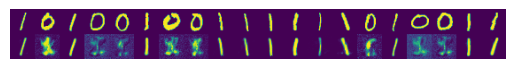

In [6]:
import matplotlib.pyplot as plt

def show(img):
  """Function for displaying image"""
  npimg = img.detach().cpu().numpy()
  plt.imshow(np.transpose(npimg, (1, 2, 0)))
  plt.axis('off')

test_dataloader = DataLoader(
  test_anomalies,
  batch_size = 20
)

with torch.no_grad():
  X, y = next(iter(test_dataloader))
  X, y = X.to(device), y.to(device)
  reconstructed = model(X)
  show(torch.concat([X, reconstructed], axis=2).transpose(2, 3).reshape(1, 20*28, 2*28).transpose(1, 2))

## Denoising Images

You can also use autoencoders to denoise images. You do this by adding some noise to your training images and then ask the autoencoder to predict the image without noise.

Let's build a dataset that adds noise to images from MNIST.

## Denoising Images

In [7]:
import torch
from torch.utils.data import Dataset
from datasets import load_dataset
import numpy as np

class MNISTNoise(Dataset):
  def __init__(self, train=False):
    self.dataset = load_dataset("ylecun/mnist")
    if train:
      self.dataset = self.dataset["train"]
    else:
      self.dataset = self.dataset["test"]

  def __len__(self):
    return len(self.dataset)

  def __getitem__(self, idx):
    target = torch.from_numpy(np.asarray(self.dataset[idx]["image"], dtype="int32") / 255).to(torch.float)
    target = target.view(1, 28, 28)

    noise = torch.zeros(1, 28, 28, dtype=torch.float)
    image = target + (0.1**0.5)*torch.randn(1, 28, 28)

    return image, target

train = MNISTNoise(train=True)
test = MNISTNoise(train=False)

## Denoising Images

Now we can train an autoencoder on this data, we will use the exact same architecture as we defined previously.

In [8]:
#| output-location: slide
from torch.utils.data import DataLoader
from tqdm import tqdm
import sys

# Use GPU if available
device = torch.accelerator.current_accelerator().type if torch.accelerator.is_available() else "cpu"
print(f"Using {device} device")

model = Autoencoder().to(device)

# Some hyperparametes
learning_rate = 0.001
epochs = 10
batch_size = 128

loss_fn = nn.MSELoss().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

train_dataloader = DataLoader(
  train,
  batch_size=batch_size,
  shuffle=True
)

test_dataloader = DataLoader(
  test,
  batch_size = len(test)
)

def train_epoch(dataloader, model, loss_fn, optimizer):
  model.train() # Set model to training mode

  total_loss = 0
  total_batches = 0

  with tqdm(dataloader, unit="batch", file=sys.stdout) as ep_tqdm:
    ep_tqdm.set_description("Train")
    for X, y in ep_tqdm:
      X, y = X.to(device), y.to(device)

      # Forward pass
      pred = model(X)
      loss = loss_fn(pred, y)
        
      # Backward pass
      loss.backward()
      optimizer.step()

      # Reset the computed gradients back to zero
      optimizer.zero_grad()

      # Output stats
      total_loss += loss
      total_batches += 1
      ep_tqdm.set_postfix(average_batch_loss=(total_loss/total_batches).item())

def eval_epoch(dataloader, model, loss_fn):
  model.eval() # Set model to inference mode
  
  total_loss = 0
  total_batches = 0
  total_samples = 0
  total_correct = 0

  with torch.no_grad(): # Do not compute gradients
    with tqdm(dataloader, unit="batch", file=sys.stdout) as ep_tqdm:
      ep_tqdm.set_description("Val")
      for X, y in ep_tqdm:
        X, y = X.to(device), y.to(device)
        pred = model(X)

        total_loss += loss_fn(pred, y)
        total_batches += 1

        ep_tqdm.set_postfix(average_batch_loss=(total_loss/total_batches).item())

# Organize the training loop
for t in range(epochs):
  print(f"Epoch {t+1}\n-------------------------------")
  train_epoch(train_dataloader, model, loss_fn, optimizer)
  eval_epoch(test_dataloader, model, loss_fn)

print("Done!")

Using cuda device
Epoch 1
-------------------------------
Val: 100%|██████████| 1/1 [00:01<00:00,  1.09s/batch, average_batch_loss=0.0215]
Epoch 2
-------------------------------
Val: 100%|██████████| 1/1 [00:00<00:00,  1.04batch/s, average_batch_loss=0.0143]
Epoch 3
-------------------------------
Val: 100%|██████████| 1/1 [00:00<00:00,  1.03batch/s, average_batch_loss=0.0119]
Epoch 4
-------------------------------
Val: 100%|██████████| 1/1 [00:00<00:00,  1.04batch/s, average_batch_loss=0.0109]
Epoch 5
-------------------------------
Val: 100%|██████████| 1/1 [00:01<00:00,  1.04s/batch, average_batch_loss=0.0101]
Epoch 6
-------------------------------
Val: 100%|██████████| 1/1 [00:00<00:00,  1.04batch/s, average_batch_loss=0.00961]
Epoch 7
-------------------------------
Val: 100%|██████████| 1/1 [00:01<00:00,  1.05s/batch, average_batch_loss=0.00934]
Epoch 8
-------------------------------
Val: 100%|██████████| 1/1 [00:00<00:00,  1.04batch/s, average_batch_loss=0.00902]
Epoch 9
---

## Denoising Images

Let's display and see if it works.

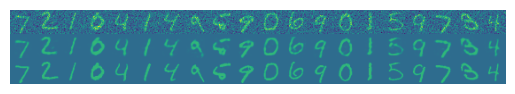

In [9]:
test_dataloader = DataLoader(
  test,
  batch_size = 20
)

with torch.no_grad():
  X, y = next(iter(test_dataloader))
  X = X.to(device)
  pred = model(X).cpu()
  X = X.cpu()
  show(torch.concat([X, pred, y], axis=2).transpose(2, 3).reshape(1, 20*28, 3*28).transpose(1, 2))

## DDPM

We can take this denoising idea much further and generate images from random noise.

Here we will cover denoising diffusion probabilistic models (DDPM) as defined in this [paper](https://arxiv.org/abs/2006.11239). DDPM is the idea behind generative models such as DALLE-2 and Stable Diffusion.

The goal is to train a model capable of generating images that are similar to the ones seen during training.

## DDPM

Suppose $x_0$ is a vector representing an image in the training set. We first add gaussian noise to it in $T$ steps using the formula
$$
  x_t = \sqrt{1-\beta_t}x_{t-1}+\sqrt{\beta_t} \varepsilon,
$$
where $\varepsilon$ is drawn from the standard normal distribution (so gaussian with mean zero and variance 1) and $\beta_1, \dots, \beta_T$ are parameters called the variance schedule. In the original paper the $\beta_t$ were taken to vary linearly from 0.0001 to 0.02 so we will do the same.

## DDPM

We can get $x_t$ in one formula straight from $x_0.$ Denote $\alpha_t=1-\beta_t$ and $\overline{\alpha}_t = \prod_{s=1}^t \alpha_s.$

Then iteratively applying the previous formula and using the fact that a linear combination of gaussians is again a gaussian we get
$$
  x_t = \sqrt{\overline{\alpha}_t}x_0 + \sqrt{1-\overline{\alpha}_t}\varepsilon.
$$

## DDPM

Now the idea of DDPM is to train a model that is able to reverse this "noisefication" process. I.e. we want a model $p$ that is able to predict $x_{t-1}$ given $x_t.$

Actually, if you shuffle the math around you'll see that it is enough to predict the noise that was added during step $t$.

## DDPM

The algorithm for training such a model and generating an image is a follows (taken from the original paper):

![](../images/ddpm.png){fig-align="center"}

Note that what we've given here is an intuitive introduction to DDPM, if you want to fully understand the math behind it you'll have to read the paper. Also, $\sigma_t = \sqrt{\beta_t}$ in our case.

## DDPM

Let's implement DDPM, we'll train it on MNIST.

In [10]:
import torch
from torch.utils.data import Dataset
from datasets import load_dataset, concatenate_datasets
import numpy as np

class MNIST(Dataset):
  def __init__(self):
    self.dataset = load_dataset("ylecun/mnist")
    self.dataset = concatenate_datasets([self.dataset["train"], self.dataset["test"]])

  def __len__(self):
    return len(self.dataset)

  def __getitem__(self, idx):
    image = torch.from_numpy(np.asarray(self.dataset[idx]["image"], dtype="int32") / 255).to(torch.float)
    image = 2*image-1
    image = image.view(1, 28, 28)

    return image

data = MNIST()

## DDPM

Now let's define a class that is going to add noise to images, predict the added noise and generate images.

In [11]:
class DDPM():
  def __init__(self, model, image_dim, device, no_steps=300, min_beta=0.0001, max_beta=0.02):
    super().__init__()
    self.no_steps = no_steps
    self.model = model
    self.image_dim = image_dim
    self.device = device
    self.betas = torch.linspace(min_beta, max_beta, no_steps).to(self.device)
    self.alphas = 1 - self.betas
    self.alpha_bars = torch.tensor([torch.prod(self.alphas[:i + 1]) for i in range(len(self.alphas))]).to(self.device)

  def add_noise(self, x0, t, noise=None):
    a_bar = self.alpha_bars[t]

    if noise is None:
      noise = torch.randn(x0.shape).to(self.device)

    return a_bar.sqrt().reshape(-1, 1, 1, 1) * x0 + (1 - a_bar).sqrt().reshape(-1, 1, 1, 1) * noise

  def predict_noise(self, x, t):
    return self.model(x, t)

  def sample(self, n_samples=10):
    self.model.eval()
    with torch.no_grad():
      c, h, w = self.image_dim
      x = torch.randn(n_samples, c, h, w).to(self.device)

      for idx, t in enumerate(list(range(ddpm.no_steps))[::-1]):
        t_tensor = (torch.ones(n_samples, 1) * t).to(self.device).long()
        noise = self.predict_noise(x, t_tensor)

        # Partially denoising the image
        x = (1 / self.alphas[t].sqrt()) * (x - (1 - self.alphas[t]) / (1 - self.alpha_bars[t]).sqrt() * noise)

        if t > 0:
          x = x + self.betas[t].sqrt() * torch.randn(n_samples, c, h, w).to(self.device)

      # Normalizing the image
      for i in range(len(x)):
        x[i] -= torch.min(x[i])
        x[i] *= 255 / torch.max(x[i])

      return x

## DDPM

Now we need some sort of model to predict the added noise. The only hard requirement is that the input shape would be the same as the output shape.

The original paper used a U-Net, so let's use it as well. U-Nets are convolutional neural networks that look like this:

![](../images/unet.png){fig-align="center"}

## DDPM

We also need to tell the network on which denoising step we are on. In the original paper sinusoidal embeddings were used so let's use them as well.

Let $d$ denote the embedding dimension and $t$ the denoising step, then sinusoidal embedding is defined as follows:
$$
  \text{SinusoidalEmbedding}_{t, 2i} = \sin \left(\frac{t}{10000^{2i/d}}\right),
$$
$$
  \text{SinusoidalEmbedding}_{t, 2i+} = \cos \left(\frac{t}{10000^{2i/d}}\right).
$$

## DDPM

Let's build our U-net.

In [12]:
#| output-location: slide
from torch import nn

class UNet(nn.Module):
  def _make_fc(self, dim_in, dim_out):
    return nn.Sequential(
      nn.Linear(dim_in, dim_out),
      nn.ReLU(),
      nn.Linear(dim_out, dim_out)
    )

  def _make_conv(self, in_channels, out_channels, kernel_size=(3, 3)):
    return nn.Sequential(
      nn.BatchNorm2d(in_channels),
      nn.Conv2d(
        in_channels=in_channels,
        out_channels=out_channels,
        kernel_size=kernel_size,
        padding=1
      ),
      nn.ReLU(),
      nn.BatchNorm2d(out_channels),
      nn.Conv2d(
        in_channels=out_channels,
        out_channels=out_channels,
        kernel_size=kernel_size,
        padding=1
      ),
      nn.ReLU(),
    )

  def _sinusoidal_embedding(self, n, d):
    embedding = torch.zeros(n, d)
    wk = torch.tensor([1 / 10_000 ** (2 * j / d) for j in range(d)])
    wk = wk.reshape((1, d))
    t = torch.arange(n).reshape((n, 1))
    embedding[:,::2] = torch.sin(t * wk[:,::2])
    embedding[:,1::2] = torch.cos(t * wk[:,::2])

    return embedding

  def __init__(self, n_steps=1000, embed_dim=128):
    super().__init__()

    self.time_embedding = nn.Embedding.from_pretrained(self._sinusoidal_embedding(n_steps, embed_dim), freeze=True)

    # Down
    self.time_embed1 = self._make_fc(embed_dim, 1)
    self.block1 = nn.Sequential(
      self._make_conv(
        in_channels=1,
        out_channels=32,
      ),
      self._make_conv(
        in_channels=32,
        out_channels=32,
      ),
      self._make_conv(
        in_channels=32,
        out_channels=32,
      ),
    )
    self.down1 = nn.Conv2d(
      in_channels=32,
      out_channels=32,
      kernel_size=(4, 4),
      stride=2,
      padding=1
    )

    self.time_embed2 = self._make_fc(embed_dim, 32)
    self.block2 = nn.Sequential(
      self._make_conv(
        in_channels=32,
        out_channels=64,
      ),
      self._make_conv(
        in_channels=64,
        out_channels=64,
      ),
      self._make_conv(
        in_channels=64,
        out_channels=64,
      ),
    )
    self.down2 = nn.Conv2d(
      in_channels=64,
      out_channels=64,
      kernel_size=(4, 4),
      stride=2,
      padding=1
    )

    self.time_embed3 = self._make_fc(embed_dim, 64)
    self.block3 = nn.Sequential(
      self._make_conv(
        in_channels=64,
        out_channels=128,
      ),
      self._make_conv(
        in_channels=128,
        out_channels=128,
      ),
      self._make_conv(
        in_channels=128,
        out_channels=128,
      ),
    )

    # Up
    self.up1 = nn.ConvTranspose2d(
      in_channels=128,
      out_channels=128,
      kernel_size=(4, 4),
      stride=2,
      padding=1
    )
    self.up_time_embed1 = self._make_fc(embed_dim, 192)
    self.up_block1 = nn.Sequential(
      self._make_conv(
        in_channels=192,
        out_channels=128,
      ),
      self._make_conv(
        in_channels=128,
        out_channels=128,
      ),
      self._make_conv(
        in_channels=128,
        out_channels=64,
      ),
    )

    self.up2 = nn.ConvTranspose2d(
      in_channels=64,
      out_channels=64,
      kernel_size=(4, 4),
      stride=2,
      padding=1
    )
    self.up_time_embed2 = self._make_fc(embed_dim, 96)
    self.up_block2 = nn.Sequential(
      self._make_conv(
        in_channels=96,
        out_channels=64,
      ),
      self._make_conv(
        in_channels=64,
        out_channels=64,
      ),
      self._make_conv(
        in_channels=64,
        out_channels=32,
      ),
    )

    self.out_conv = nn.Conv2d(
      in_channels=32,
      out_channels=1,
      kernel_size=(3, 3),
      padding=1,
    )

  def forward(self, x, t):
    t = self.time_embedding(t)
    b = len(x)

    down1 = self.block1(x + self.time_embed1(t).reshape(b, -1, 1, 1))
    down2 = self.block2(self.down1(down1) + self.time_embed2(t).reshape(b, -1, 1, 1))
    down3 = self.block3(self.down2(down2) + self.time_embed3(t).reshape(b, -1, 1, 1))

    up1 = self.up_block1(
      torch.cat([down2, self.up1(down3)], dim=1) + self.up_time_embed1(t).reshape(b, -1, 1, 1)
    )
    up2 = self.up_block2(
      torch.cat([down1, self.up2(up1)], dim=1) + self.up_time_embed2(t).reshape(b, -1, 1, 1)
    )

    return self.out_conv(up2)

print(UNet())

UNet(
  (time_embedding): Embedding(1000, 128)
  (time_embed1): Sequential(
    (0): Linear(in_features=128, out_features=1, bias=True)
    (1): ReLU()
    (2): Linear(in_features=1, out_features=1, bias=True)
  )
  (block1): Sequential(
    (0): Sequential(
      (0): BatchNorm2d(1, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (1): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (2): ReLU()
      (3): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (4): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (5): ReLU()
    )
    (1): Sequential(
      (0): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (1): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (2): ReLU()
      (3): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (4): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), paddin

## DDPM

We can now train the model.

In [13]:
#| output-location: slide
from torch.utils.data import DataLoader

# Hyperparameters
learning_rate = 0.0001
epochs = 20
batch_size = 128
no_steps = 1000

device = torch.accelerator.current_accelerator().type if torch.accelerator.is_available() else "cpu"
print(f"Using {device} device")

model = UNet(n_steps=no_steps).to(device)
ddpm = DDPM(
  model = model,
  image_dim = (1, 28, 28),
  device = device,
  no_steps = no_steps
)

dataloader = DataLoader(
  data,
  batch_size=batch_size,
  shuffle=True
)

loss_fn = nn.MSELoss().to(device)
optimizer = torch.optim.Adam(params=model.parameters(), lr=learning_rate)

def train_epoch(dataloader, model, loss_fn, optimizer):
  model.train() # Set model to training mode

  total_loss = 0
  total_batches = 0

  with tqdm(dataloader, unit="batch", file=sys.stdout) as ep_tqdm:
    ep_tqdm.set_description("Train")
    for X in ep_tqdm:
      X = X.to(device)
      noise = torch.randn(X.shape).to(device)
      t = torch.randint(0, no_steps, (len(X),)).to(device)

      # Forward pass
      image_w_noise = ddpm.add_noise(X, t, noise)
      predicted_noise = ddpm.predict_noise(image_w_noise, t)
      loss = loss_fn(predicted_noise, noise)
        
      # Backward pass
      loss.backward()
      optimizer.step()

      # Reset the computed gradients back to zero
      optimizer.zero_grad()

      # Output stats
      total_loss += loss
      total_batches += 1
      ep_tqdm.set_postfix(average_batch_loss=(total_loss/total_batches).item())

# Organize the training loop
for t in range(epochs):
  print(f"Epoch {t+1}\n-------------------------------")
  train_epoch(dataloader, model, loss_fn, optimizer)

torch.save(model, 'ddpm_unet.pth')
print("Done!")

Using cuda device
Epoch 1
-------------------------------
Train: 100%|██████████| 547/547 [00:22<00:00, 23.84batch/s, average_batch_loss=0.241]
Epoch 2
-------------------------------
Train: 100%|██████████| 547/547 [00:22<00:00, 23.96batch/s, average_batch_loss=0.0743]
Epoch 3
-------------------------------
Train: 100%|██████████| 547/547 [00:22<00:00, 23.99batch/s, average_batch_loss=0.0563]
Epoch 4
-------------------------------
Train: 100%|██████████| 547/547 [00:22<00:00, 23.95batch/s, average_batch_loss=0.0478]
Epoch 5
-------------------------------
Train: 100%|██████████| 547/547 [00:22<00:00, 23.93batch/s, average_batch_loss=0.0437]
Epoch 6
-------------------------------
Train: 100%|██████████| 547/547 [00:22<00:00, 23.95batch/s, average_batch_loss=0.0402]
Epoch 7
-------------------------------
Train: 100%|██████████| 547/547 [00:22<00:00, 23.93batch/s, average_batch_loss=0.038] 
Epoch 8
-------------------------------
Train: 100%|██████████| 547/547 [00:22<00:00, 23.94bat

## DDPM

Le's generate some images.

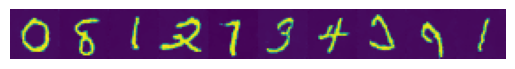

In [14]:
import matplotlib.pyplot as plt

def show(img):
  """Function for displaying image"""
  npimg = img.detach().cpu().numpy()
  plt.imshow(np.transpose(npimg, (1, 2, 0)))
  plt.axis('off')

show(ddpm.sample(n_samples=10).transpose(2, 3).reshape(1, 10*28, 28).transpose(1, 2))

## Practice task

Try to augment the sampling procedure such that you would be able to specify the digit that you want to sample.

You can do this using Algorithm 2 from this [paper](https://arxiv.org/abs/2105.05233).

You can find the trained model for denoising [here](https://github.com/jputrius/ml_intro/tree/main/models).